In [ ]:
import json
import requests
from qiskit import QuantumCircuit, transpile
from qiskit.qasm2 import dumps 
 

In [2]:
# ---- Grover pieces ---- THE FUNCTIONS
def oracle_all_ones(qc: QuantumCircuit, qubits):
    """
    Phase-flip the state |11..1> on 'qubits' using an MCZ implemented as:
      H(last); MCX(controls -> last); H(last)
    """
    last = qubits[-1]
    ctrls = qubits[:-1]
    qc.h(last)
    # noancilla avoids needing extra qubits; it can be deep, but stays within 30 qubits
    qc.mcx(ctrls, last, mode="noancilla")
    qc.h(last)

def diffusion(qc: QuantumCircuit, qubits):
    """
    Standard diffusion operator:
      H^n X^n (MCZ) X^n H^n
    """
    qc.h(qubits)
    qc.x(qubits)
    oracle_all_ones(qc, qubits)
    qc.x(qubits)
    qc.h(qubits)


In [19]:
# ---- Build 30-qubit Grover circuit ----
n = 15
qc = QuantumCircuit(n, n)

# 1) Uniform superposition
qc.h(range(n))

# 2) Grover iterations (starting with 1)
iterations = 10
for _ in range(iterations):
    oracle_all_ones(qc, list(range(n)))
    diffusion(qc, list(range(n)))

# 3) Measure
qc.measure(range(n), range(n))

C:\Users\elena\AppData\Local\Temp\ipykernel_67348\1106402236.py:11: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(ctrls, last, mode="noancilla")
C:\Users\elena\AppData\Local\Temp\ipykernel_67348\1106402236.py:11: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(ctrls, last, mode="noan

In [20]:
# ---- Decompose/transpile to a simple basis (helps QASM2 compatibility) ----
# You can broaden basis_gates if your backend accepts more than u/cx.
#qc_t = transpile(qc, basis_gates=["u", "cx"], optimization_level=1)

qc_t = transpile(qc, basis_gates=["u3", "cx"], optimization_level=1)


# ---- Export OpenQASM 2 ----
program_30q = dumps(qc_t)
print(program_30q[:500], "\n...\n")  # preview


OPENQASM 2.0;
include "qelib1.inc";
qreg q[15];
creg c[15];
u3(pi/2,0,pi) q[0];
u3(pi/2,0,pi) q[1];
u3(pi/2,0,pi) q[2];
u3(pi/2,0,pi) q[3];
u3(pi/2,0,pi) q[4];
u3(pi/2,0,pi) q[5];
u3(pi/2,0,pi) q[6];
u3(pi/2,0,pi) q[7];
u3(pi/2,0,pi) q[8];
u3(pi/2,0,pi) q[9];
u3(pi/2,0,pi) q[10];
u3(pi/2,0,pi) q[11];
u3(0,pi/2,-pi/2) q[12];
cx q[4],q[12];
u3(0,0,-pi/4) q[12];
cx q[11],q[12];
u3(0,0,pi/4) q[12];
cx q[4],q[12];
u3(0,0,pi/4) q[4];
u3(0,0,-pi/4) q[12];
cx q[11],q[12];
cx q[11],q[4];
u3(0,0,-pi/4) q[ 
...



In [ ]:
# ---- Send to Quokka like you already do ----
#my_quokka = "theq-adc1cf"
my_quokka = 'quokka1'
request_http = f"http://{my_quokka}.quokkacomputing.com/qsim/qasm"

data = {
    "script": program_30q,
    "count": 10
}

result = requests.post(request_http, json=data, verify=False)
counts = json.loads(result.content)

print(counts)

c:\Users\elena\miniconda3\envs\cwq311\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'quokka1.quokkacomputing.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

Counts:
0101111101 1
1111111111 4
0010001010 1
1111101001 1
0001100011 1
0111110010 1
1110010000 1


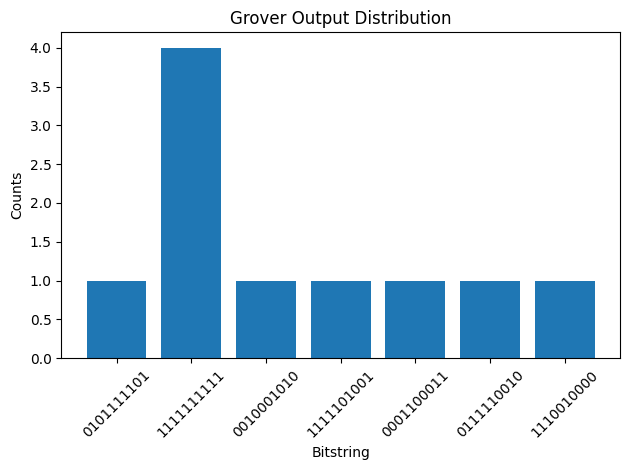

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

# Extract raw shots
shots = counts["result"]["c"]   # list of lists like [1,1,1,1,0]

# Convert to bitstrings
bitstrings = ["".join(str(b) for b in shot) for shot in shots]

# Count frequencies
freq = Counter(bitstrings)

print("Counts:")
for k, v in freq.items():
    print(k, v)

# ---- Plot histogram ----
labels = list(freq.keys())
values = [freq[k] for k in labels]

plt.figure()
plt.bar(labels, values)
plt.xlabel("Bitstring")
plt.ylabel("Counts")
plt.title("Grover Output Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
